In [71]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet

In [72]:
u_train = np.load('u_train.npy')
output_train = np.load('output_train.npy')
u_test = np.load('u_test.npy')

In [105]:
def create_arx_regressor(y, u, n, m, d):
    N = len(y)
    p = max(n, d + m)
    print(p)
    
    X = []
    Y = []
    
    for k in range(p, N):
        # Past values of y(k), autoregressive part
        y_lags = [y[k - i] for i in range(1, n+1)]
        
        # Past values of u(k), exogenous input part
        u_lags = [u[k - d - j] for j in range(m + 1)]
        
        # Combine both sets of lags into a single row
        X.append(y_lags + u_lags)
        Y.append(y[k])
    return np.array(X), np.array(Y)

In [106]:
n, m, d = 2, 5, 4
p = max(n,d+m)
X_train, Y_train = create_arx_regressor(output_train, u_train, n, m, d)
sample_size = X_train.shape[0]
test_size = int(0.3*sample_size)
X_train_split = X_train[:-test_size] 
Y_train_split = Y_train[:-test_size]  
index = X_train_split.shape[0]
X_val_split = X_train[-test_size:]  
Y_val_split = Y_train[-test_size:]  
print("Original set X shape:", X_train.shape)
print("Training set X shape:", X_train_split.shape)
print("Training set Y shape:", Y_train_split.shape)
print("Validation set X shape:", X_val_split.shape)
print("Validation set Y shape:", Y_val_split.shape)

9
Original set X shape: (2031, 8)
Training set X shape: (1422, 8)
Training set Y shape: (1422,)
Validation set X shape: (609, 8)
Validation set Y shape: (609,)


[-0.61944421 -1.08862488]
[[-1.08862488 -0.61944421 -5.         ... -5.         -5.
  -5.        ]
 [-0.25254548 -1.08862488 -5.         ... -5.         -5.
  -5.        ]
 [ 0.71115316 -0.25254548 -5.         ... -5.         -5.
  -5.        ]
 ...
 [ 5.06508197  2.83921742  5.         ...  5.          5.
   5.        ]
 [ 6.25651479  5.06508197  5.         ...  5.          5.
   5.        ]
 [ 6.01250205  6.25651479  5.         ...  5.          5.
   5.        ]]
[np.float64(-1.0886248780986774), np.float64(-0.6194442145825236)]


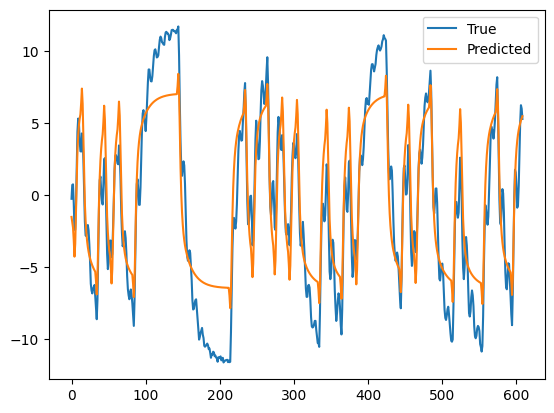

Validation set R2 score: 0.7162024508067925


In [107]:
lr = LinearRegression()
lr.fit(X_train_split, Y_train_split)
y_pred_val_OLS = []
aux = np.zeros(n)
print(Y_train_split[-n:])
print(X_val_split)
y_prev = list(Y_train_split[-n:][::-1])
print(y_prev)
for k in range(test_size):
    u_lags = [u_train[index + p + k - d - j] for j in range(m + 1)]
    y_pred = lr.predict([y_prev + u_lags])
    y_pred_val_OLS.append(y_pred[0])
    for l in range(n):
        aux[l] = y_prev[l]
    y_prev[0] = y_pred[0]
    for i in range(1,n):
        y_prev[i] = aux[i-1]
plt.plot(Y_val_split, label='True')
plt.plot(y_pred_val_OLS, label='Predicted')
plt.legend()
plt.show()
print("Validation set R2 score:", r2_score(y_pred_val_OLS, Y_val_split))

In [55]:
alpha = np.linspace(0.0001, 1, 1000)
ratios = np.linspace(0.0001, 1, 100)
lasso_mse_array = []
ridge_mse_array = []
lasso_r2_array = []
ridge_r2_array = []

for i in range(0,len(alpha)):
    y_pred_val_lasso = []
    y_pred_val_ridge = []
    lasso = Lasso(alpha=alpha[i],fit_intercept=True)
    lasso.fit(X_train_split, Y_train_split)
    for k in range(test_size):
        u_lags = [u_train[index + p + k - d - j] for j in range(m + 1)]
        y_pred = lasso.predict([y_prev + u_lags])
        y_pred_val_lasso.append(y_pred[0])
        aux1= y_prev[0]
        aux2 = y_prev[1]
        aux3 = y_prev[2]
        y_prev[0] = y_pred[0]
        y_prev[1] = aux1
        y_prev[2] = aux2
    lasso_mse = mean_squared_error(Y_val_split, y_pred_val_lasso)
    lasso_mse_array.append([alpha[i], lasso_mse])
    lasso_r2_array.append([alpha[i], r2_score(y_pred_val_lasso, Y_val_split)])
    
    ridge = Ridge(alpha=alpha[i],fit_intercept=True)
    ridge.fit(X_train_split, Y_train_split)
    for k in range(test_size):
        u_lags = [u_train[index + p + k - d - j] for j in range(m + 1)]
        y_pred = ridge.predict([y_prev + u_lags])
        y_pred_val_ridge.append(y_pred[0])
        aux1= y_prev[0]
        aux2 = y_prev[1]
        aux3 = y_prev[2]
        y_prev[0] = y_pred[0]
        y_prev[1] = aux1
        y_prev[2] = aux2
    ridge_mse = mean_squared_error(Y_val_split, y_pred_val_ridge)
    ridge_mse_array.append([alpha[i], ridge_mse])
    ridge_r2_array.append([alpha[i], r2_score(y_pred_val_ridge, Y_val_split)])

lasso_mse_array = np.array(lasso_mse_array)
ridge_mse_array = np.array(ridge_mse_array)

fig, axes = plt.subplots(1, 2, figsize=(30, 7))
axes[0].plot(lasso_mse_array[:,0], lasso_mse_array[:,1], color='blue', linewidth=2, label='Lasso')
axes[0].set_title('Lasso Regression MSE')
axes[0].set_xlabel('Alpha')                
axes[0].set_ylabel('MSE')                  
axes[1].plot(ridge_mse_array[:,0], ridge_mse_array[:,1], color='red', linewidth=2, label='Ridge')
axes[1].set_title('Ridge Regression MSE') 
axes[1].set_xlabel('Alpha')               
axes[1].set_ylabel('MSE')                  
plt.tight_layout() 
plt.show()

/home/goncaloribeiro/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.288e+01, tolerance: 6.280e+00
  model = cd_fast.enet_coordinate_descent(
/home/goncaloribeiro/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.265e+01, tolerance: 6.280e+00
  model = cd_fast.enet_coordinate_descent(
/home/goncaloribeiro/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regula

KeyboardInterrupt: 

In [43]:
print(lasso_r2_array)
print(ridge_r2_array)

[[np.float64(0.0001), 0.9588118553462591], [np.float64(0.001100900900900901), 0.9580829234510522], [np.float64(0.0021018018018018015), 0.9572121716692945], [np.float64(0.0031027027027027026), 0.9563375080089123], [np.float64(0.004103603603603604), 0.9554279427514266], [np.float64(0.005104504504504504), 0.9544108472171946], [np.float64(0.006105405405405406), 0.9533956048762889], [np.float64(0.0071063063063063064), 0.9523916520077736], [np.float64(0.008107207207207206), 0.9513963042803293], [np.float64(0.009108108108108108), 0.9504022521966714], [np.float64(0.010109009009009007), 0.9494190680579939], [np.float64(0.011109909909909909), 0.9484358692637008], [np.float64(0.01211081081081081), 0.9474538372961337], [np.float64(0.01311171171171171), 0.9464822592972744], [np.float64(0.014112612612612612), 0.9455063737426771], [np.float64(0.015113513513513512), 0.9445438053171341], [np.float64(0.016114414414414413), 0.9435783486783448], [np.float64(0.017115315315315315), 0.9426100770031282], [np.

In [ ]:

for i in alpha:
    for j in ratios:
        y_pred_val_en = []
        en_mse_array = []
        en_r2_array = []
        en = ElasticNet(alpha=i, l1_ratio=j)
        en.fit(X_train_split, Y_train_split)
        for k in range(test_size):
            u_lags = [u_train[index + p + k - d - j] for j in range(m + 1)]
            y_pred = en.predict([y_prev + u_lags])
            y_pred_val_en.append(y_pred[0])
            aux1= y_prev[0]
            aux2 = y_prev[1]
            aux3 = y_prev[2]
            y_prev[0] = y_pred[0]
            y_prev[1] = aux1
            y_prev[2] = aux2
        en_mse = mean_squared_error(Y_val_split, y_pred_val_en)
        en_mse_array.append([i, j, en_mse])
        en_r2_array.append([i,j, r2_score(y_pred_val_en, Y_val_split)])

en_mse_array = np.array(en_mse_array)
L1_ratio_results = pd.DataFrame(en_mse_array, columns=['Alpha', 'L1_Ratio', 'MSE']).sort_values(by='MSE')
print(L1_ratio_results.head())